# DSCI Group 20 Project Final Report

Group members: 

- Hannah Yin 
- 

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction

## Methods & Results

In [3]:
# load the dataset we are working with

players <- read_csv("https://raw.githubusercontent.com/ahnnahy/dsci100-group20-project/refs/heads/main/players%20(1).csv")

players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [4]:
set.seed(100)

players <- players |>
    mutate(subscribed = as_factor(subscribe))
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age,subscribed
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,TRUE
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,TRUE
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57,FALSE
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,FALSE
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,TRUE


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


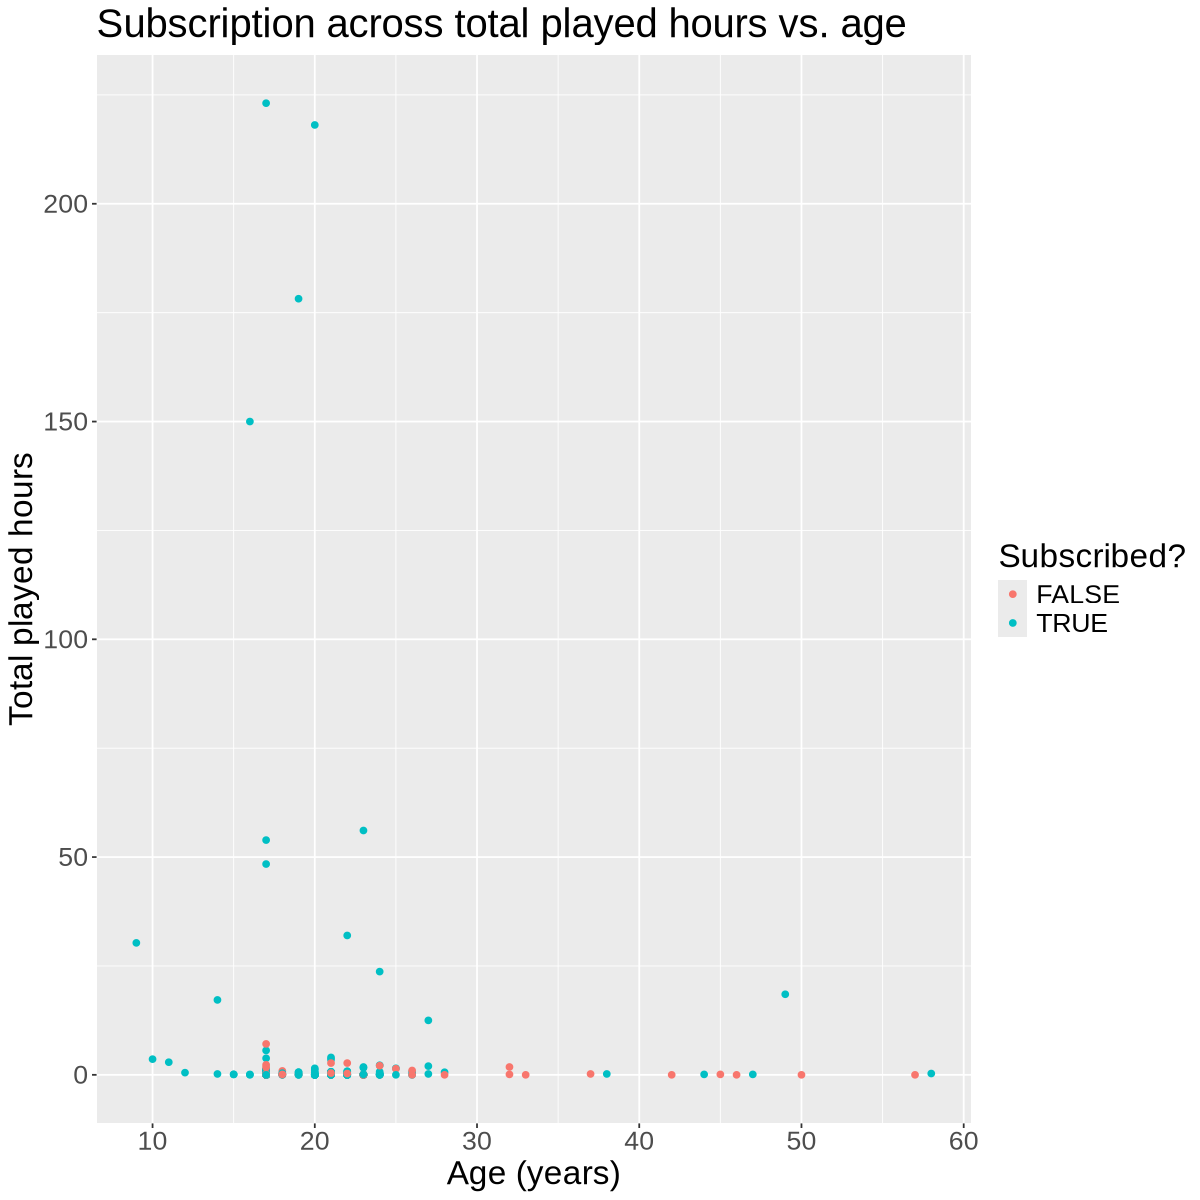

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)

players_plot <- ggplot(players, aes(x = Age, y = played_hours, colour = subscribed)) +
    geom_point() +
    labs(x = "Age (years)", y = "Total played hours", color = "Subscribed?", title = "Subscription across total played hours vs. age") +
    theme(text = element_text(size = 20))

        

players_plot

In [11]:
players_split <- initial_split(players, prop = 0.75, strata = subscribed)
players_train <- training(players_split)
players_test <- testing(players_split)

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribed)

players_recipe <- recipe(subscribed ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- player_results |>
  filter(.metric == "accuracy")

accuracies


→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

There were issues with some computations   A: x2

There were issues with some computations   A: x2





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5164477,3,0.02661586,Preprocessor1_Model001
2,accuracy,binary,0.5049535,3,0.02085776,Preprocessor1_Model002
3,accuracy,binary,0.5850301,3,0.07557271,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
98,accuracy,binary,0.7358238,3,0.007568868,Preprocessor1_Model098
99,accuracy,binary,0.7358238,3,0.007568868,Preprocessor1_Model099
100,accuracy,binary,0.7358238,3,0.007568868,Preprocessor1_Model100


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.7596333,3,0.03101146,Preprocessor1_Model019


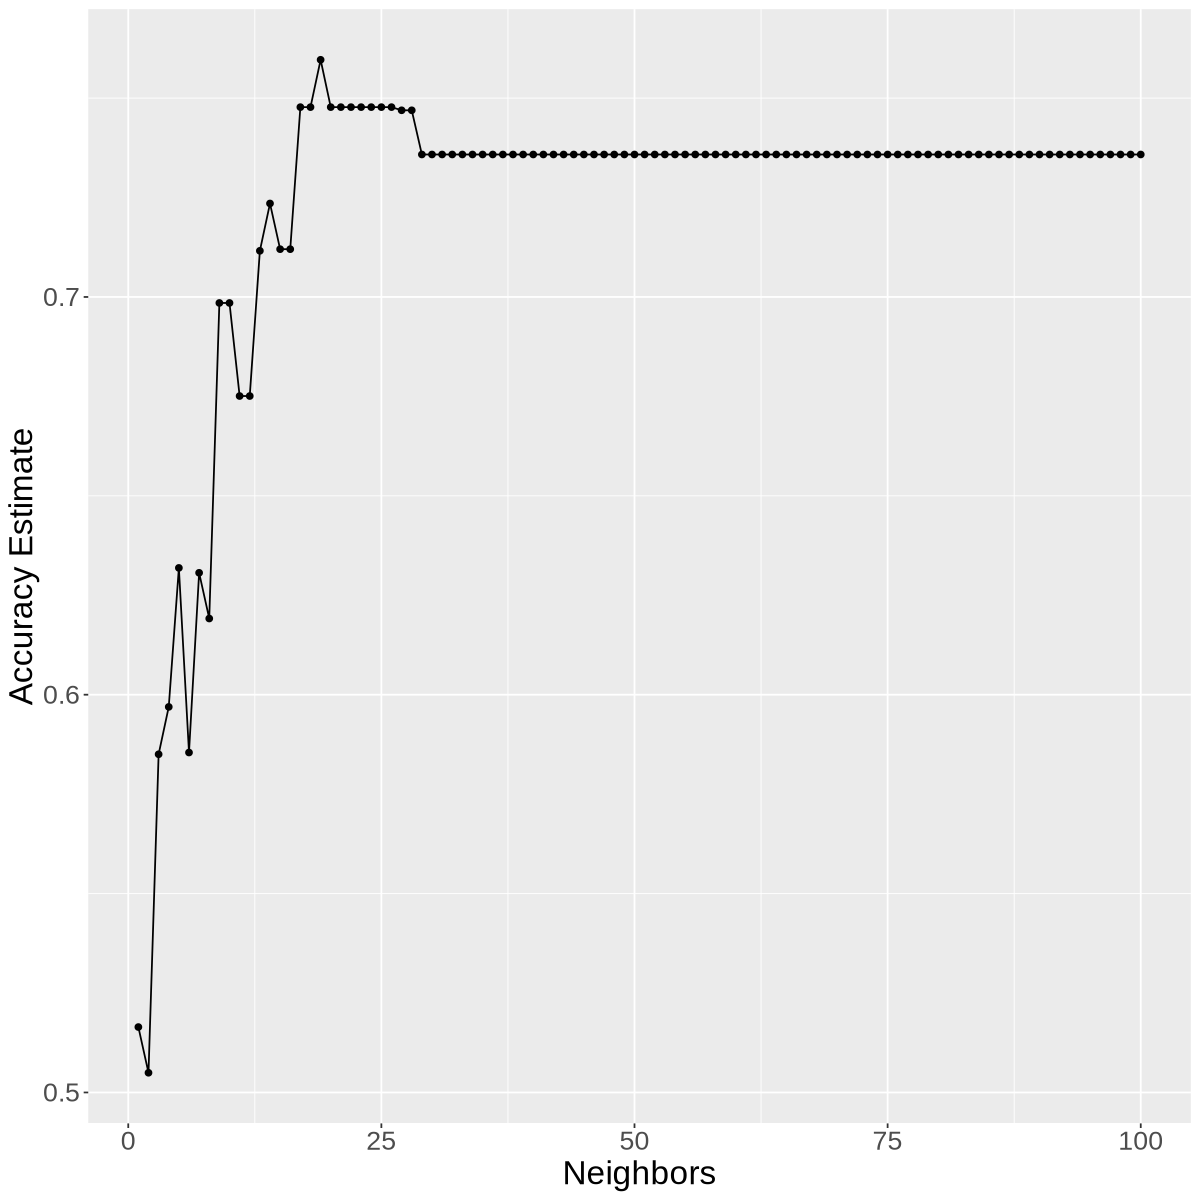

In [21]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 20))

best_k <- accuracies |>
    slice_max(mean, n = 1)

accuracy_vs_k
best_k

We can see above that the best k value to use here is k = 19. We will now run k = 19 on our cross-validation and test on the testing set. 

In [24]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("classification")

player_best_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_best_spec) |>
  fit(data=players_train)

player_test_predictions <- predict(player_best_results, players_test) |>
  bind_cols(players_test)

player_test_predictions |>
  metrics(truth = subscribed, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


## Discussion

## References